# Description

In [ ]:
# In this notebook you will find an examples of GAN
#     that is trained on a MNIST fasion data
#     that can be executed on a local machine.

# You will first see how a simple
#     Sequantila Deep Neural Network can do this work.
# On the next step Convolutional layers are added, that allows to find identify
#     relevan patterns. That allows to achieve better results.
    
# Also note, that loss function of generator of a simple NN goes up,
#     meaning that Descriminator outperforms Generator. Howevere
#     adding Convolutional layers indeed changes the game and Generator
#     can now trick Discirminator showing the same trend of the loss function.

# Libs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sys, os

import tensorflow as tf

from tensorflow import keras
from keras import layers, models
import keras.backend as K

2023-05-30 16:31:31.711129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Functions

In [ ]:
# functions for visualization

def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

def show_reconstructions(predictions, n_images=12):
    fig = plt.figure(figsize=(n_images*1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1+image_index)
        plot_image(predictions[image_index])

# function that run fitting
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    """
    Description:
        i. creates generator and discriminator objects
        ii. to train discriminator set of fake data is generated
            then disciriminator is trained on fake and real data (X_fake_and_real)
        iii. generator is trained by tricking (fake=real) discirminator (untrainable)
    Input:
        * NNs for generator and discriminator
        * dataset for training
        * desired bathc_size and size for the nose input
        * epoch number of epoches
    Return:
        * trains generator and discriminator models
        * retursn lists of losses (averaged over batch)
    """
    generator, discirminator = gan.layers
    d_loss, g_loss = [], []
    for epoch in range(n_epochs):
        d_epoch, g_epoch = [], []
        for num,X_batch in enumerate(dataset):
            
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X, Y = tf.cast(generated_images, tf.float32), tf.cast(X_batch, tf.float32)
            X_fake_and_real = tf.concat([X, Y], axis=0)
            y = tf.constant([0.]*batch_size + [1.]*batch_size)
            discriminator.trainable=True
            d_l = discriminator.train_on_batch(X_fake_and_real, y)
            d_epoch.append(d_l)

            noise = tf.random.normal(shape=[batch_size, codings_size])
            y = tf.constant([1.]*batch_size)
            discirminator.trainable = False
            g_l = gan.train_on_batch(noise, y)
            g_epoch.append(g_l)
            
        d_mean = np.mean(d_epoch)
        g_mean = np.mean(g_epoch)
        d_loss.append(d_mean)
        g_loss.append(g_mean)
        print(f'epoch: {epoch}/{n_epochs}; d_loss: {d_mean}, g_loss: {g_mean}')
        if np.mean(g_loss)/np.mean(d_loss)>5:
            break
    return d_loss, g_loss

# Flat

In [33]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

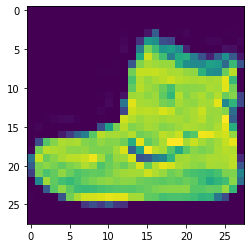

In [32]:
# fashin MNIST example
plt.imshow(X_train_full[0])

In [34]:
X_train = X_train/255.0
X_test = X_test/255.0

In [35]:
K.clear_session()

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[codings_size]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28,28])
    ]
)

discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(1, activation='sigmoid')
    ]
)

gan = keras.models.Sequential([generator, discriminator])

In [36]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable=False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [37]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
d_loss, g_loss = train_gan(gan, dataset, batch_size, codings_size)

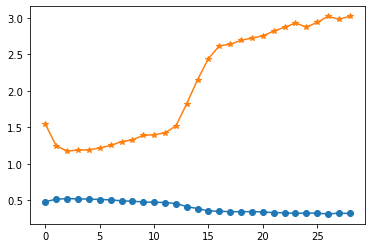

In [47]:
plt.plot(d_loss, "-o")
plt.plot(g_loss, "-*")

In [40]:
codings = tf.random.normal(shape=[12,codings_size])
images = generator(codings).numpy()

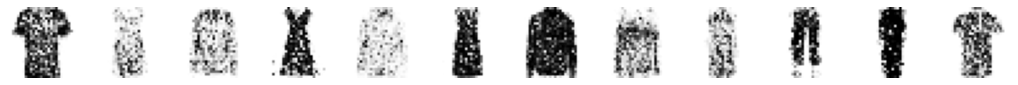

In [43]:
show_reconstructions(images)

# Convolution

In [149]:
# implementation of Functional API
K.clear_session()

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7*7*128, input_shape=[codings_size]),
    keras.layers.Reshape([7,7,128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh')   
]
)

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same',
                        activation=keras.layers.LeakyReLU(0.2), input_shape=[28,28,1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same',
                       activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
] 
)

gan = keras.models.Sequential([generator, discriminator])

In [150]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable=False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [151]:
X_train_sc = X_train.reshape(-1, 28,28,1)*2-1

batch_size = 100
dataset = tf.data.Dataset.from_tensor_slices(X_train_sc).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
d_loss, g_loss = train_gan(gan, dataset, batch_size, codings_size, n_epochs=50)

In [157]:
codings = tf.random.normal(shape=[12,codings_size])
images = generator(codings).numpy()

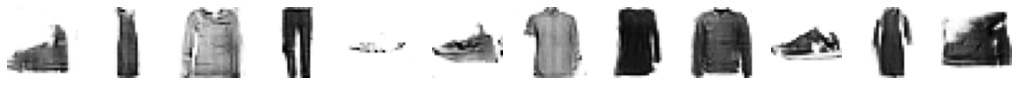

In [158]:
# generated images
show_reconstructions(images)

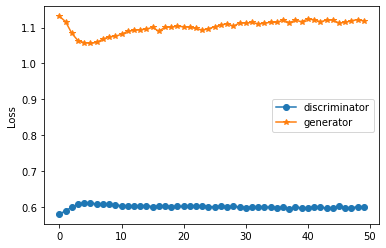

In [162]:
plt.plot(d_loss, "-o", label = "discriminator")
plt.plot(g_loss, "-*", label = "generator")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# As is expected implementation of conv. layers gives
# better results because it can identify important patterns